In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import random
from collections import deque
from xai import *
import gymnasium as gym
import os

In [23]:
i = 3
path = f"images/misalignment{i}.png"
dst = f"images/dqn-shap/misalignment{i}"

try:
    os.mkdir(dst)
except FileExistsError:
    pass

im = plt.imread(path)

names = np.array([
    ["original",        None,           "eap-q-noop",   "eap-q-right",  "ecp-q-noop",   "ecp-q-right"],
    ["observation",     "latent-shap",  "eap-q-up",     "eap-q-fire",   "ecp-q-up",     "ecp-q-fire"],
    ["reconstruction",  None,           "eap-q-left",   "eap-q-sum",    "ecp-q-left",   "ecp-q-sum"],
])

h = im.shape[0]//3
w = im.shape[1]//6

for i,column in enumerate(names):
    for j,name in enumerate(column):
        if name is None:
            continue
        plt.imsave(f"{dst}/{name}.png", im[i*h:(i+1)*h,j*w:(j+1)*w])

In [6]:
im.shape

(2520, 3840, 4)

In [5]:

env = Asteroids()
observation, rewards = env.reset()

def step(action: Action) -> Callable[[], Tuple[Observation, Tuple[Reward,...]]]:
    return lambda: env.step(action, False)

with Window(name="Asteroids", fps=60, scale=4) as window:
    with Recorder(filename="game-footage.mp4", fps=24, scale=4) as recorder:
        cases = {
            **{action.key_bind:step(action) for action in Actions},
            "q": lambda: window.break_window(),
            }
        try:
            while True:
                if not env.running():
                    observation, rewards = env.reset()

                original = observation.numpy(normalize=False)
                y, x = observation.find_player()
                translated = observation.translated((y-60, x+50)).numpy(False)
                centered = observation.translated().numpy(False)
                image = np.hstack([original,translated,centered])
                recorder(image)
                observation, rewards = window(image).match(cases)
        except WindowClosed:
            pass

In [6]:

env = Asteroids()
observation, rewards = env.reset()

def rotate_image(image, angle):
  image_center = tuple(np.array(image[18:195].shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = image.copy()
  result[18:195] = cv2.warpAffine(image[18:195], rot_mat, image[18:195].shape[1::-1], flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)
  return result

def step(action: Action) -> Callable[[], Tuple[Observation, Tuple[Reward,...]]]:
    return lambda: env.step(action, False)

with Window(name="Asteroids", fps=60, scale=4) as window:
    with Recorder(filename="game-footage.mp4", fps=24, scale=4) as recorder:
        cases = {
            **{action.key_bind:step(action) for action in Actions},
            "q": lambda: window.break_window(),
            }
        try:
            r = 0.0
            y,x = 0,0
            while True:
                if not env.running():
                    observation, rewards = env.reset()

                original = observation.translated().numpy(False)
                angle = observation.spaceship_angle
                pos = observation.find_player()
                if angle is not None:
                    r = -angle.degrees().float()

                rotated = rotate_image(original, 160)
                aligned = rotate_image(original, r)
                image = np.hstack([original,rotated,aligned])
                recorder(image)
                observation, rewards = window(image).match(cases)
        except WindowClosed:
            pass

In [7]:
env = gym.make("Asteroids-v4", render_mode="rgb_array")

In [8]:
try:
    env.reset()
    cv2.namedWindow("Asteroids", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Asteroids", 4*160, 4*210)
    buffer = deque(maxlen=30)
    observation,info = env.reset()
    observation, reward, truncated, done, info = env.step(0)
    while not done and not truncated:
        observation, reward, truncated, done, info = env.step(env.action_space.sample())
        image = env.render()
        buffer.append(image)
        cv2.imshow("Asteroids", image[:,:,::-1])
        key = cv2.waitKey(50)
        if key == ord("q"):
            break
        elif key == ord("s"):
            fig = plt.figure(dpi=250, figsize=(14,6))
            for i,im in enumerate(buffer):
                fig.add_subplot(3,10,i+1)
                plt.imshow(im.repeat(4,0).repeat(4,1))
                plt.axis('off')
                plt.title(f"${i+1}$", size=15)

            fig.tight_layout()
            plt.legend()
            plt.show()

        
finally:
    cv2.destroyAllWindows()

WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.


Text(0, 0.5, 'N')

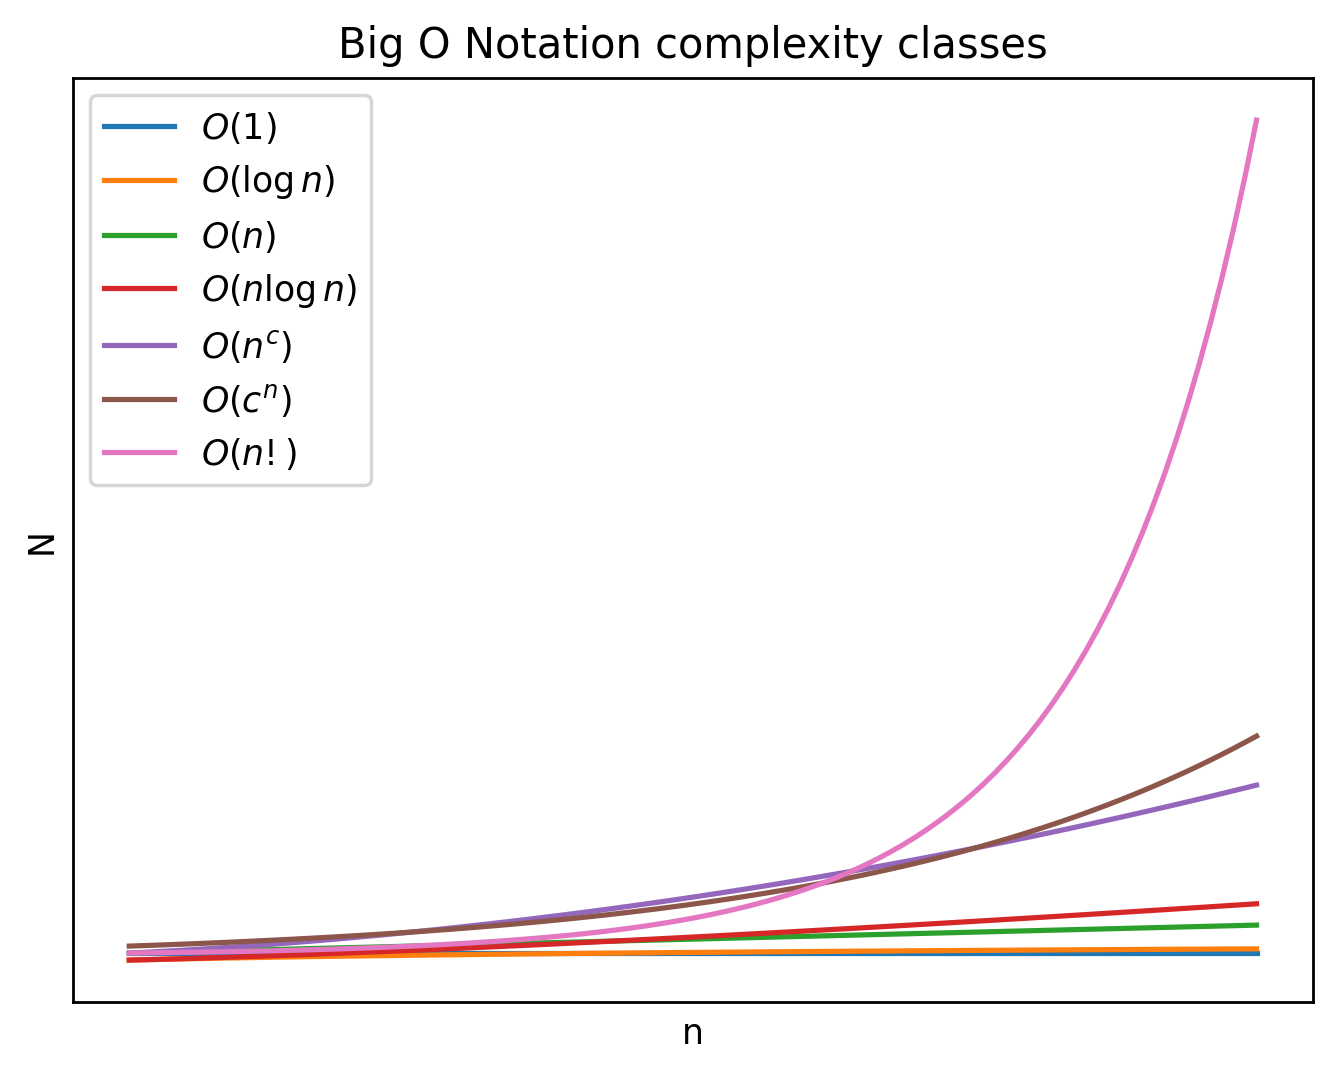

In [9]:
n = np.linspace(1,5,100)
fig = plt.figure(dpi=250)
plt.plot(n, np.vectorize(lambda n: 1)(n), label=f"$O(1)$")
plt.plot(n, np.vectorize(lambda n: np.log(n))(n), label=f"$O(\log{{n}})$")
plt.plot(n, np.vectorize(lambda n: n)(n), label=f"$O(n)$")
plt.plot(n, np.vectorize(lambda n: n*np.log(n))(n), label=f"$O(n\log{{n}})$")
plt.plot(n, np.vectorize(lambda n: n**2)(n), label=f"$O(n^c)$")
plt.plot(n, np.vectorize(lambda n: 2**n)(n), label=f"$O(c^n)$")
plt.plot(n, np.vectorize(lambda n: math.gamma(n+1))(n), label=f"$O(n!)$")
plt.legend()
plt.grid()
plt.xticks([], [])
plt.yticks([], [])
plt.title("Big O Notation complexity classes")
plt.xlabel("n")
plt.ylabel("N")

In [10]:

env = Asteroids()
observation, rewards = env.reset()

def rotate_image(image, angle):
  image_center = tuple(np.array(image[18:195].shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = image.copy()
  result[18:195] = cv2.warpAffine(image[18:195], rot_mat, image[18:195].shape[1::-1], flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)
  return result

actions = (
    Actions.UP,
    Actions.LEFT,
    Actions.RIGHT,
    Actions.FIRE,
    Actions.NOOP
)

def step(action: Action) -> Callable[[], Tuple[Observation, Tuple[Reward,...]]]:
    return lambda: env.step(random.sample(actions, 1)[0], False, steps=4)

with Window(name="Asteroids", fps=60, scale=4) as window:
    with Recorder(filename="game-footage.mp4", fps=24, scale=4) as recorder:
        cases = {
            **{action.key_bind:step(action) for action in Actions},
            "q": lambda: window.break_window(),
            }
        try:
            r = 0.0
            y,x = 0,0
            while True:
                if not env.running():
                    observation, rewards = env.reset()

                image = observation.numpy(False)
                recorder(image)
                observation, rewards = window(image).match(cases)
        except WindowClosed:
            pass

In [24]:
def correct_avg(avg: float, warmup_time: float, number_of_samples: int = 10):
    return ((avg*number_of_samples) - warmup_time)/number_of_samples

In [30]:
correct_avg(0.315, 0.35)

0.27999999999999997